In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
data = 'https://raw.githubusercontent.com/alexeygrigorev/datasets/master/car_fuel_efficiency.csv'
!wget $data

--2025-10-07 13:31:31--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/car_fuel_efficiency.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8001::154, 2606:50c0:8002::154, 2606:50c0:8003::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8001::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 874188 (854K) [text/plain]
Saving to: ‘car_fuel_efficiency.csv’

car_fuel_efficiency 100%[===================>] 853,70K  2,28MB/s    in 0,4s    

2025-10-07 13:31:31 (2,28 MB/s) - ‘car_fuel_efficiency.csv’ saved [874188/874188]



In [8]:
df_all = pd.read_csv('car_fuel_efficiency.csv')
df_all.head()

,engine_displacement,num_cylinders,horsepower,vehicle_weight,acceleration,model_year,origin,fuel_type,drivetrain,num_doors,fuel_efficiency_mpg
0,170,3.0,159.0,3413.433759,17.7,2003,Europe,Gasoline,All-wheel drive,0.0,13.231729
1,130,5.0,97.0,3149.664934,17.8,2007,USA,Gasoline,Front-wheel drive,0.0,13.688217
2,170,NaN,78.0,3079.038997,15.1,2018,Europe,Gasoline,Front-wheel drive,0.0,14.246341
3,220,4.0,NaN,2542.392402,20.2,2009,USA,Diesel,All-wheel drive,2.0,16.912736
4,210,1.0,140.0,3460.870990,14.4,2009,Europe,Gasoline,All-wheel drive,2.0,12.488369


## Exploring data set

In [9]:
#Clean column names
df_all.columns = df_all.columns.str.lower().str.replace(' ', '_')
df_all.columns

Index(['engine_displacement', 'num_cylinders', 'horsepower', 'vehicle_weight',
       'acceleration', 'model_year', 'origin', 'fuel_type', 'drivetrain',
       'num_doors', 'fuel_efficiency_mpg'],
      dtype='object')

In [15]:
df = df_all.loc[:, ["engine_displacement", "horsepower", "vehicle_weight", "model_year", "fuel_efficiency_mpg"]]
for col in df.columns:
    print(col)
    print(df[col].unique()[:5])
    print(df[col].nunique()) #number of unique values
    print('---')

engine_displacement
[170 130 220 210 190]
36
---
horsepower
[159.  97.  78.  nan 140.]
192
---
vehicle_weight
[3413.43375861 3149.66493422 3079.03899737 2542.39240183 3460.87098999]
9704
---
model_year
[2003 2007 2018 2009 2008]
24
---
fuel_efficiency_mpg
[13.23172891 13.68821744 14.246341   16.9127356  12.48836912]
9704
---


### Q1: EDA

<Axes: xlabel='fuel_efficiency_mpg', ylabel='Count'>

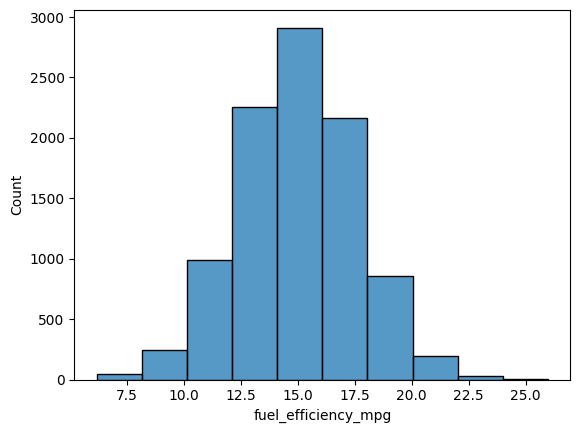

In [18]:
sns.histplot(df.fuel_efficiency_mpg, bins=10)

### Q1: missing values

In [16]:
df.isnull().sum()

engine_displacement      0
horsepower             708
vehicle_weight           0
model_year               0
fuel_efficiency_mpg      0
dtype: int64

### Q2: median (50% percintile) horsepower

In [20]:
df.horsepower.median()

np.float64(149.0)

## Splitting data set

In [21]:
n = len(df)
n_val = int(n * 0.2)
n_test = int(n * 0.2)
n_train = n - n_val - n_test

In [22]:
idx = np.arange(n)
np.random.seed(42) #to make it reproducible
np.random.shuffle(idx)

In [27]:
#Splitting with shuffling
df_train = df.iloc[idx[:n_train]]
df_val = df.iloc[idx[n_train:n_train+n_val]]
df_test = df.iloc[idx[n_train+n_val:]]

In [28]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

### Q3: Treating missing values

In [37]:
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    
    return w_full[0], w_full[1:]

def rmse(y, y_pred):
    se = (y - y_pred) ** 2
    mse = se.mean()
    return np.sqrt(mse)

In [30]:
df_train.horsepower.isnull().sum()  

np.int64(429)

In [38]:
df_train_zeros = df_train.copy()
df_train_zeros['horsepower'] = df_train_zeros['horsepower'].fillna(0)
y_train_zeros = df_train_zeros.fuel_efficiency_mpg.values
del df_train_zeros['fuel_efficiency_mpg']
X_train_zeros = df_train_zeros.values
w0, w = train_linear_regression(X_train_zeros, y_train_zeros)
y_pred = w0 + X_train_zeros.dot(w)
rmse(y_train_zeros, y_pred)

np.float64(0.5202614265099076)

In [39]:
df_train_mean = df_train.copy()
df_train_mean['horsepower'] = df_train_mean['horsepower'].fillna(df_train_mean['horsepower'].mean())
y_train_mean = df_train_mean.fuel_efficiency_mpg.values
del df_train_mean['fuel_efficiency_mpg']
X_train_mean = df_train_mean.values
w0, w = train_linear_regression(X_train_mean, y_train_mean)
y_pred = w0 + X_train_mean.dot(w)
rmse(y_train_mean, y_pred)

np.float64(0.4624412137959964)

### Q4: Different regularization

In [63]:
def train_linear_regression_reg(X, y, reg):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX = XTX + reg * np.eye(XTX.shape[0])

    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    
    return w_full[0], w_full[1:]

In [40]:
df['horsepower'] = df['horsepower'].fillna(0)

In [41]:
#Splitting with shuffling
df_train = df.iloc[idx[:n_train]]
df_val = df.iloc[idx[n_train:n_train+n_val]]
df_test = df.iloc[idx[n_train+n_val:]]

In [50]:
df_train.head()

,engine_displacement,horsepower,vehicle_weight,model_year,fuel_efficiency_mpg
0,220,144.0,2535.887591,2009,16.642943
1,160,141.0,2741.170484,2019,16.298377
2,230,155.0,2471.880237,2017,18.591822
3,150,206.0,3748.164469,2015,11.818843
4,300,111.0,2135.716359,2006,19.402209


In [42]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [ ]:
X_train = df_train.loc[:, ["engine_displacement", "horsepower", "vehicle_weight", "model_year"]].values
y_train = df_train.fuel_efficiency_mpg.values

X_val = df_val.loc[:, ["engine_displacement", "horsepower", "vehicle_weight", "model_year"]].values
y_val = df_val.fuel_efficiency_mpg.values


np.float64(0.5173782638841655)

In [65]:
for r in [0, 0.01, 0.1, 1, 5, 10, 100]:
    w0, w = train_linear_regression_reg(X_train, y_train, r)
    y_pred = w0 + X_val.dot(w)
    print(r, rmse(y_val, y_pred))

0 0.5173782638841655
0.01 0.517111552576255
0.1 0.5187525130701096
1 0.5222348802092595
5 0.522891609282353
10 0.5229812979636556
100 0.5230636233819932


### Q5. Testing seed

In [ ]:
scores = []
for s in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]:
    idx = np.arange(n)
    np.random.seed(s) #to make it reproducible
    np.random.shuffle(idx)

    #Splitting with shuffling
    df_train = df.iloc[idx[:n_train]]
    df_val = df.iloc[idx[n_train:n_train+n_val]]

    df_train = df_train.reset_index(drop=True)
    df_val = df_val.reset_index(drop=True)
    X_train = df_train.loc[:, ["engine_displacement", "horsepower", "vehicle_weight", "model_year"]].values
    y_train = df_train.fuel_efficiency_mpg.values

    X_val = df_val.loc[:, ["engine_displacement", "horsepower", "vehicle_weight", "model_year"]].values
    y_val = df_val.fuel_efficiency_mpg.values

    w0, w = train_linear_regression(X_train, y_train)
    y_pred = w0 + X_val.dot(w)
    scores.append(rmse(y_val, y_pred))


In [68]:
np.std(scores)

np.float64(0.006989446425505432)

### Q6

In [77]:
idx = np.arange(n)
np.random.seed(9) #to make it reproducible
np.random.shuffle(idx)

In [78]:
#Splitting with shuffling
df_train = df.iloc[idx[:n_train]]
df_val = df.iloc[idx[n_train:n_train+n_val]]
df_test = df.iloc[idx[n_train+n_val:]]

In [79]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

df_combined = pd.concat([df_train, df_val])
df_combined = df_combined.reset_index(drop=True)
df_combined['horsepower'] = df_combined['horsepower'].fillna(0)

In [80]:
X_combined = df_combined.loc[:, ["engine_displacement", "horsepower", "vehicle_weight", "model_year"]].values
y_combined = df_combined.fuel_efficiency_mpg.values

X_test = df_test.loc[:, ["engine_displacement", "horsepower", "vehicle_weight", "model_year"]].values
y_test = df_test.fuel_efficiency_mpg.values

In [81]:
r=0.001
w0, w = train_linear_regression_reg(X_combined, y_combined, r)
y_pred = w0 + X_val.dot(w)
rmse(y_test, y_pred)

np.float64(3.503110238124814)